In [55]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [56]:
import sys
sys.path.insert(0,"..")
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
torchaudio.set_audio_backend('sox_io')
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import psutil

from utils import *
from datasets import *
from models import *
from profiler import WingbeatDatasetProfiler

# Cleaning Settings

In [77]:
maxpeaks = 15
minpeaks = 1
maxscore = 15
minscore = 2.5
minduration = 100
selection = f"peaks>={minpeaks} & peaks<={maxpeaks} & score>{minscore} & score<={maxscore} & duration>={minduration}"

# Dataset SD

In [187]:
dataset_sd = WingbeatDatasetProfiler(dsname="/mnt/HGST_4TB/Datasets/Fruitflies_flytrap_rpi/from_sd/Suzukii//", bandpass_low=140., bandpass_high=1500., rpiformat=False, custom_label=[0])

Found 2725 in dataset: /mnt/HGST_4TB/Datasets/Fruitflies_flytrap_rpi/from_sd/Suzukii//, and 1 label(s): ['Suzukii']
Label(s) changed to [0]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Duration
Sum..
Max..
Filename..
Date..
Date string..
Datehour string..
Finished.


# Dataset RPi

In [188]:
dataset_rpi = WingbeatDatasetProfiler(dsname="/mnt/HGST_4TB/Datasets/Fruitflies_flytrap_rpi/from_rpi/Suzukii//", bandpass_low=140., bandpass_high=1500., rpiformat=True, custom_label=[0])
df_rpi.head()

Found 128 in dataset: /mnt/HGST_4TB/Datasets/Fruitflies_flytrap_rpi/from_rpi/Suzukii//, and 1 label(s): ['Suzukii']
Label(s) changed to [0]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Duration
Sum..
Max..
Filename..
Date..
Date string..
Datehour string..
Finished.


,x,y,idx,score,peaks,peaksxtra,duration,sum,max,fname,date,datestr,datehourstr
1,/mnt/HGST_4TB/Datasets/Fruitflies_flytrap_rpi/from_rpi/Melanogaster/test/20220111_171301_Tna_Hna_unknown.wav,0,1,6.391271,4,"[219, 438, 445, 656]",215.000,13.388885,0.016998,20220111_171301_Tna_Hna_unknown,2022-01-11 17:13:01,20220111,220111_17
2,/mnt/HGST_4TB/Datasets/Fruitflies_flytrap_rpi/from_rpi/Melanogaster/test/20220111_171521_Tna_Hna_unknown.wav,0,2,9.939533,11,"[190, 198, 208, 219, 395, 402, 411, 617, 814, 820, 1224]",269.125,18.850159,0.033295,20220111_171521_Tna_Hna_unknown,2022-01-11 17:15:21,20220111,220111_17
3,/mnt/HGST_4TB/Datasets/Fruitflies_flytrap_rpi/from_rpi/Melanogaster/test/20220111_171713_Tna_Hna_unknown.wav,0,3,5.984199,2,"[167, 335]",188.500,15.353180,0.020599,20220111_171713_Tna_Hna_unknown,2022-01-11 17:17:13,20220111,220111_17
9,/mnt/HGST_4TB/Datasets/Fruitflies_flytrap_rpi/from_rpi/Melanogaster/test/20220111_172415_Tna_Hna_unknown.wav,0,9,5.189040,2,"[207, 411]",160.375,14.170654,0.021637,20220111_172415_Tna_Hna_unknown,2022-01-11 17:24:15,20220111,220111_17
10,/mnt/HGST_4TB/Datasets/Fruitflies_flytrap_rpi/from_rpi/Melanogaster/test/20220111_172605_Tna_Hna_unknown.wav,0,10,4.271136,4,"[199, 398, 404, 597]",484.125,31.322662,0.027161,20220111_172605_Tna_Hna_unknown,2022-01-11 17:26:05,20220111,220111_17


# Comparison

In [189]:
df_rpi = dataset_rpi.df.query(selection)
print('rpi')
print(df_rpi.shape)
df_sd = dataset_sd.df.query(selection)
print('sd')
print(df_sd.shape)
df_sd = df_sd.sample(df_rpi.shape[0])
print('downsampling')
print(df_sd.shape)

rpi
(106, 13)
sd
(1931, 13)
downsampling
(106, 13)


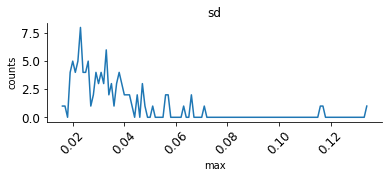

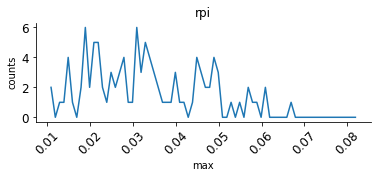

In [200]:
plt.subplot(2,1,1);plt.title('sd')
np_hist(df_sd, 'max', res=0.001)
plt.subplot(2,1,2);plt.title('rpi')
np_hist(df_rpi, 'max', res=0.001)

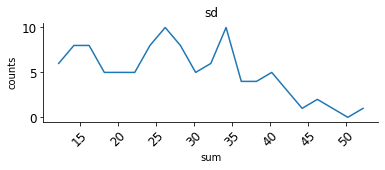

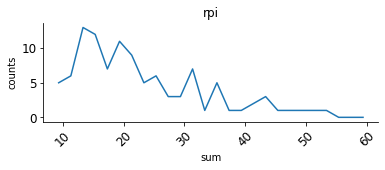

In [198]:
plt.subplot(2,1,1);plt.title('sd')
np_hist(df_sd, 'sum', res=2, )
plt.subplot(2,1,2);plt.title('rpi')
np_hist(df_rpi, 'sum', res=2)

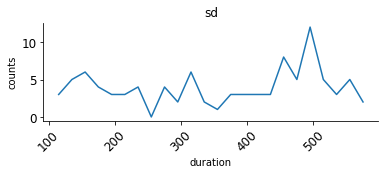

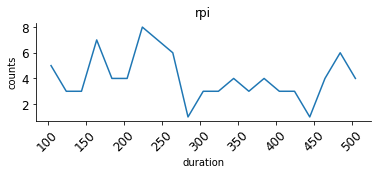

In [196]:
plt.subplot(2,1,1);plt.title('sd')
np_hist(df_sd, 'duration', res=20, )
plt.subplot(2,1,2);plt.title('rpi')
np_hist(df_rpi, 'duration', res=20)

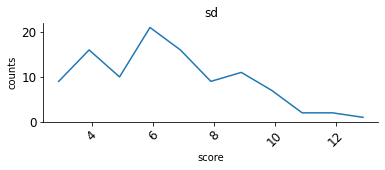

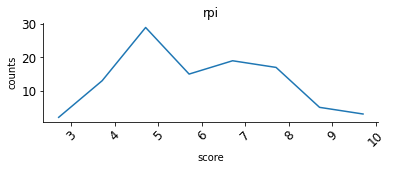

In [195]:
plt.subplot(2,1,1);plt.title('sd')
np_hist(df_sd, 'score', res=1, )
plt.subplot(2,1,2);plt.title('rpi')
np_hist(df_rpi, 'score', res=1)

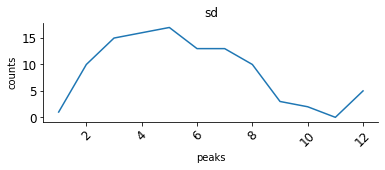

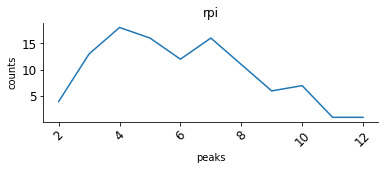

In [194]:
plt.subplot(2,1,1);plt.title('sd')
np_hist(df_sd, 'peaks', res=1, )
plt.subplot(2,1,2);plt.title('rpi')
np_hist(df_rpi, 'peaks', res=1)